# Generative Adversarial Network

## Pre-processing data

In [2]:
import tensorflow as tf
import numpy as np
from IPython.display import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
tf.reset_default_graph()

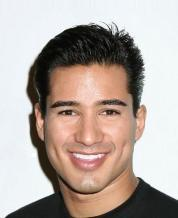

In [3]:
Image("img_align_celeba/000214.jpg") 

In [4]:
    
## Here we will get the 100 000 first images and put them in a variable 178*218*3
data_size = 25001
def get_data(data_size=25001):
        dataset = []
        for x in range(1, data_size):
            imgname = "img_align_celeba/"
            for i in range(0, 6-len(str(x))):
                imgname += "0"
            imgname += str(x) + ".jpg"
            dataset.append(mpimg.imread(imgname))
        dataset =  np.array(dataset)
        print("Data loaded. Number of images: " + str(data_size))
        return dataset
    
def get_data_normalized(data_size=25001):
        dataset = []
        for x in range(1, data_size):
            imgname = "img_align_celeba/"
            for i in range(0, 6-len(str(x))):
                imgname += "0"
            imgname += str(x) + ".jpg"
            dataset.append(mpimg.imread(imgname))
        dataset =  np.array(dataset)/256.0
        print("Data loaded. Number of images: " + str(data_size))
        return dataset
        
def get_batch(batch_size, dataset):
        indexes = np.random.randint(0, len(dataset), batch_size)
        data = dataset[indexes]
        return data

def sample_Z(batch_size=50, n=100):
        return np.random.uniform(-1., 1., size=[batch_size, n])

Data loaded. Number of images: 5
[[[0.98828125 0.90234375 0.7578125 ]
  [0.98828125 0.90234375 0.7578125 ]
  [0.98828125 0.90234375 0.7578125 ]
  ...
  [0.9609375  0.890625   0.84375   ]
  [0.99609375 0.92578125 0.87109375]
  [0.9921875  0.9296875  0.8671875 ]]

 [[0.98828125 0.90234375 0.7578125 ]
  [0.98828125 0.90234375 0.7578125 ]
  [0.98828125 0.90234375 0.7578125 ]
  ...
  [0.96875    0.8984375  0.8515625 ]
  [0.99609375 0.92578125 0.87109375]
  [0.9921875  0.9296875  0.8671875 ]]

 [[0.98828125 0.90234375 0.7578125 ]
  [0.98828125 0.90234375 0.7578125 ]
  [0.98828125 0.90234375 0.7578125 ]
  ...
  [0.9765625  0.90625    0.859375  ]
  [0.99609375 0.9296875  0.875     ]
  [0.99609375 0.93359375 0.87109375]]

 ...

 [[0.546875   0.2890625  0.1015625 ]
  [0.44921875 0.19140625 0.00390625]
  [0.5703125  0.3046875  0.12890625]
  ...
  [0.4765625  0.21484375 0.109375  ]
  [0.48046875 0.21875    0.1171875 ]
  [0.4765625  0.21875    0.1171875 ]]

 [[0.5078125  0.2421875  0.05859375]
  [0

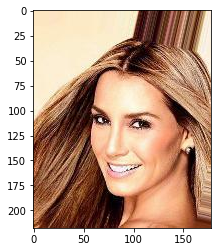

In [5]:
dat = get_data_normalized(5)
print(dat[0])
plt.imshow(dat[0])

In [6]:
def generator_mlp(Z, fc_sizes=[110,200,300], output_dim=218*178*3, reuse=False):
    
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        fc1 = tf.layers.dense(Z, fc_sizes[0], activation=tf.nn.leaky_relu)
        fc2 = tf.layers.dense(fc1, fc_sizes[1], activation=tf.nn.leaky_relu)
        fc3 = tf.layers.dense(fc2, fc_sizes[2], activation=tf.nn.leaky_relu)
        out = tf.layers.dense(fc3, output_dim)
    return out


In [7]:
def discriminator_mlp(X, fc_sizes=[110,300,200], reuse=False):
    
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,fc_sizes[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,fc_sizes[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,fc_sizes[2],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h3,1)

    return out

In [8]:
X = tf.placeholder(tf.float32,[None,218,178,3])
XX = tf.reshape(X, shape=(tf.shape(X)[0], 218*178*3))
Z = tf.placeholder(tf.float32,[None,100])

In [9]:
G_sample = generator_mlp(Z)
r_logits = discriminator_mlp(XX)
f_logits = discriminator_mlp(G_sample, reuse=True)

In [10]:
disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))


In [11]:
gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")

gen_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars) # D Train step


Data loaded. Number of images: 100
Iterations: 0	 Discriminator loss: 1.3177	 Generator loss: 0.6935
Iterations: 1	 Discriminator loss: 0.8765	 Generator loss: 0.6949
Iterations: 2	 Discriminator loss: 0.8247	 Generator loss: 0.6955
Iterations: 3	 Discriminator loss: 0.7932	 Generator loss: 0.6956
Iterations: 4	 Discriminator loss: 0.7879	 Generator loss: 0.6970
Iterations: 5	 Discriminator loss: 0.7526	 Generator loss: 0.6967
Iterations: 6	 Discriminator loss: 0.7619	 Generator loss: 0.6986
Iterations: 7	 Discriminator loss: 0.7301	 Generator loss: 0.6988
Iterations: 8	 Discriminator loss: 0.7359	 Generator loss: 0.6994
Iterations: 9	 Discriminator loss: 0.7229	 Generator loss: 0.6993
Iterations: 10	 Discriminator loss: 0.7244	 Generator loss: 0.7009
Iterations: 11	 Discriminator loss: 0.7151	 Generator loss: 0.7015
Iterations: 12	 Discriminator loss: 0.7132	 Generator loss: 0.7023
Iterations: 13	 Discriminator loss: 0.7040	 Generator loss: 0.7030
Iterations: 14	 Discriminator loss: 0

Iterations: 126	 Discriminator loss: 0.0671	 Generator loss: 2.9773
Iterations: 127	 Discriminator loss: 0.0616	 Generator loss: 3.1379
Iterations: 128	 Discriminator loss: 0.0555	 Generator loss: 3.1917
Iterations: 129	 Discriminator loss: 0.0515	 Generator loss: 3.3848
Iterations: 130	 Discriminator loss: 0.0470	 Generator loss: 3.3395
Iterations: 131	 Discriminator loss: 0.0449	 Generator loss: 3.4383
Iterations: 132	 Discriminator loss: 0.0378	 Generator loss: 3.5630
Iterations: 133	 Discriminator loss: 0.0325	 Generator loss: 3.6126
Iterations: 134	 Discriminator loss: 0.0321	 Generator loss: 3.6213
Iterations: 135	 Discriminator loss: 0.0321	 Generator loss: 3.6661
Iterations: 136	 Discriminator loss: 0.0304	 Generator loss: 3.7428
Iterations: 137	 Discriminator loss: 0.0283	 Generator loss: 3.8161
Iterations: 138	 Discriminator loss: 0.0266	 Generator loss: 3.9202
Iterations: 139	 Discriminator loss: 0.0230	 Generator loss: 3.9870
Iterations: 140	 Discriminator loss: 0.0233	 Gen

Iterations: 246	 Discriminator loss: 24.6500	 Generator loss: 15.5236
Iterations: 247	 Discriminator loss: 13.9510	 Generator loss: 20.0521
Iterations: 248	 Discriminator loss: 167.8496	 Generator loss: 0.0000
Iterations: 249	 Discriminator loss: 39.6216	 Generator loss: 0.0000
Iterations: 250	 Discriminator loss: 35.1645	 Generator loss: 0.0000
Iterations: 251	 Discriminator loss: 28.9302	 Generator loss: 0.0000
Iterations: 252	 Discriminator loss: 16.7051	 Generator loss: 0.6853
Iterations: 253	 Discriminator loss: 19.1419	 Generator loss: 0.4025
Iterations: 254	 Discriminator loss: 13.1665	 Generator loss: 5.3528
Iterations: 255	 Discriminator loss: 10.2903	 Generator loss: 10.7870
Iterations: 256	 Discriminator loss: 120.0122	 Generator loss: 0.0000
Iterations: 257	 Discriminator loss: 45.7447	 Generator loss: 0.0000
Iterations: 258	 Discriminator loss: 28.7266	 Generator loss: 0.0000
Iterations: 259	 Discriminator loss: 16.1193	 Generator loss: 4.2187
Iterations: 260	 Discriminato

Iterations: 369	 Discriminator loss: 31.6833	 Generator loss: 0.0000
Iterations: 370	 Discriminator loss: 23.2256	 Generator loss: 0.0000
Iterations: 371	 Discriminator loss: 12.4122	 Generator loss: 0.0113
Iterations: 372	 Discriminator loss: 13.5614	 Generator loss: 0.0017
Iterations: 373	 Discriminator loss: 10.4426	 Generator loss: 0.0036
Iterations: 374	 Discriminator loss: 7.3679	 Generator loss: 0.2146
Iterations: 375	 Discriminator loss: 2.1621	 Generator loss: 5.1593
Iterations: 376	 Discriminator loss: 22.3834	 Generator loss: 0.0000
Iterations: 377	 Discriminator loss: 18.6651	 Generator loss: 0.0000
Iterations: 378	 Discriminator loss: 12.8599	 Generator loss: 0.0090
Iterations: 379	 Discriminator loss: 12.1395	 Generator loss: 0.0080
Iterations: 380	 Discriminator loss: 8.6950	 Generator loss: 0.3723
Iterations: 381	 Discriminator loss: 4.6640	 Generator loss: 1.0422
Iterations: 382	 Discriminator loss: 3.5296	 Generator loss: 0.0000
Iterations: 383	 Discriminator loss: 11

Iterations: 492	 Discriminator loss: 18.6661	 Generator loss: 0.0001
Iterations: 493	 Discriminator loss: 7.3699	 Generator loss: 1.7507
Iterations: 494	 Discriminator loss: 9.8610	 Generator loss: 1.8910
Iterations: 495	 Discriminator loss: 9.8023	 Generator loss: 5.3988
Iterations: 496	 Discriminator loss: 40.6217	 Generator loss: 0.5441
Iterations: 497	 Discriminator loss: 12.4921	 Generator loss: 21.0591
Iterations: 498	 Discriminator loss: 15.2390	 Generator loss: 0.0039
Iterations: 499	 Discriminator loss: 8.1775	 Generator loss: 1.8956
Iterations: 500	 Discriminator loss: 37.0712	 Generator loss: 0.0009
Iterations: 501	 Discriminator loss: 20.3194	 Generator loss: 0.0002
Iterations: 502	 Discriminator loss: 12.5507	 Generator loss: 0.0301
Iterations: 503	 Discriminator loss: 3.7991	 Generator loss: 6.0852
Iterations: 504	 Discriminator loss: 4.1472	 Generator loss: 10.5165
Iterations: 505	 Discriminator loss: 45.9612	 Generator loss: 0.0001
Iterations: 506	 Discriminator loss: 1

Iterations: 612	 Discriminator loss: 6.7579	 Generator loss: 0.0505
Iterations: 613	 Discriminator loss: 8.5433	 Generator loss: 5.9229
Iterations: 614	 Discriminator loss: 5.4542	 Generator loss: 1.3072
Iterations: 615	 Discriminator loss: 1.5776	 Generator loss: 0.0090
Iterations: 616	 Discriminator loss: 5.7600	 Generator loss: 0.5656
Iterations: 617	 Discriminator loss: 1.4436	 Generator loss: 3.8727
Iterations: 618	 Discriminator loss: 1.0404	 Generator loss: 0.0097
Iterations: 619	 Discriminator loss: 4.2939	 Generator loss: 0.4103
Iterations: 620	 Discriminator loss: 1.9514	 Generator loss: 4.5185
Iterations: 621	 Discriminator loss: 1.7701	 Generator loss: 0.0038
Iterations: 622	 Discriminator loss: 7.2497	 Generator loss: 0.1708
Iterations: 623	 Discriminator loss: 1.9790	 Generator loss: 1.4140
Iterations: 624	 Discriminator loss: 0.3330	 Generator loss: 2.5592
Iterations: 625	 Discriminator loss: 1.3410	 Generator loss: 0.0107
Iterations: 626	 Discriminator loss: 6.4781	 Gen

Iterations: 733	 Discriminator loss: 4.8508	 Generator loss: 0.3659
Iterations: 734	 Discriminator loss: 1.6392	 Generator loss: 2.1967
Iterations: 735	 Discriminator loss: 1.0719	 Generator loss: 0.0281
Iterations: 736	 Discriminator loss: 4.5838	 Generator loss: 0.4968
Iterations: 737	 Discriminator loss: 1.4025	 Generator loss: 2.9814
Iterations: 738	 Discriminator loss: 2.5158	 Generator loss: 0.0055
Iterations: 739	 Discriminator loss: 5.8338	 Generator loss: 0.0955
Iterations: 740	 Discriminator loss: 3.2970	 Generator loss: 1.1319
Iterations: 741	 Discriminator loss: 0.8724	 Generator loss: 13.8614
Iterations: 742	 Discriminator loss: 34.5673	 Generator loss: 0.2169
Iterations: 743	 Discriminator loss: 3.6091	 Generator loss: 3.0932
Iterations: 744	 Discriminator loss: 0.9622	 Generator loss: 0.6119
Iterations: 745	 Discriminator loss: 5.0568	 Generator loss: 2.3477
Iterations: 746	 Discriminator loss: 1.1236	 Generator loss: 8.3112
Iterations: 747	 Discriminator loss: 1.0772	 G

Iterations: 858	 Discriminator loss: 5.7377	 Generator loss: 0.0000
Iterations: 859	 Discriminator loss: 18.1701	 Generator loss: 0.0001
Iterations: 860	 Discriminator loss: 11.6172	 Generator loss: 0.0298
Iterations: 861	 Discriminator loss: 5.3283	 Generator loss: 2.4267
Iterations: 862	 Discriminator loss: 1.9253	 Generator loss: 0.0055
Iterations: 863	 Discriminator loss: 6.2262	 Generator loss: 0.2972
Iterations: 864	 Discriminator loss: 1.5682	 Generator loss: 2.9169
Iterations: 865	 Discriminator loss: 2.5580	 Generator loss: 0.0029
Iterations: 866	 Discriminator loss: 5.3273	 Generator loss: 0.2253
Iterations: 867	 Discriminator loss: 2.1586	 Generator loss: 2.1435
Iterations: 868	 Discriminator loss: 1.6844	 Generator loss: 0.0258
Iterations: 869	 Discriminator loss: 4.2928	 Generator loss: 0.5510
Iterations: 870	 Discriminator loss: 1.1179	 Generator loss: 2.3170
Iterations: 871	 Discriminator loss: 1.9603	 Generator loss: 0.0162
Iterations: 872	 Discriminator loss: 3.8820	 G

Iterations: 983	 Discriminator loss: 1.0804	 Generator loss: 0.3069
Iterations: 984	 Discriminator loss: 1.6569	 Generator loss: 2.3201
Iterations: 985	 Discriminator loss: 1.5086	 Generator loss: 0.1460
Iterations: 986	 Discriminator loss: 2.3229	 Generator loss: 1.6475
Iterations: 987	 Discriminator loss: 0.8153	 Generator loss: 0.4700
Iterations: 988	 Discriminator loss: 1.2267	 Generator loss: 1.8369
Iterations: 989	 Discriminator loss: 1.1155	 Generator loss: 0.1672
Iterations: 990	 Discriminator loss: 1.9938	 Generator loss: 2.1406
Iterations: 991	 Discriminator loss: 1.2148	 Generator loss: 0.2565
Iterations: 992	 Discriminator loss: 1.9250	 Generator loss: 2.1596
Iterations: 993	 Discriminator loss: 1.1974	 Generator loss: 0.5581
Iterations: 994	 Discriminator loss: 1.2284	 Generator loss: 1.9032
Iterations: 995	 Discriminator loss: 1.2290	 Generator loss: 0.2333
Iterations: 996	 Discriminator loss: 1.9602	 Generator loss: 1.4578
Iterations: 997	 Discriminator loss: 0.8827	 Gen

Iterations: 1103	 Discriminator loss: 0.8703	 Generator loss: 1.5611
Iterations: 1104	 Discriminator loss: 0.9741	 Generator loss: 0.2365
Iterations: 1105	 Discriminator loss: 2.0168	 Generator loss: 2.7931
Iterations: 1106	 Discriminator loss: 1.9045	 Generator loss: 0.1416
Iterations: 1107	 Discriminator loss: 3.1576	 Generator loss: 1.1155
Iterations: 1108	 Discriminator loss: 5.4153	 Generator loss: 61.4342
Iterations: 1109	 Discriminator loss: 65.9575	 Generator loss: 0.0001
Iterations: 1110	 Discriminator loss: 10.9406	 Generator loss: 25.6202
Iterations: 1111	 Discriminator loss: 26.0006	 Generator loss: 0.0568
Iterations: 1112	 Discriminator loss: 4.6850	 Generator loss: 2.5552
Iterations: 1113	 Discriminator loss: 0.6433	 Generator loss: 1.8133
Iterations: 1114	 Discriminator loss: 0.6929	 Generator loss: 0.4579
Iterations: 1115	 Discriminator loss: 1.1643	 Generator loss: 2.5547
Iterations: 1116	 Discriminator loss: 1.3535	 Generator loss: 0.0675
Iterations: 1117	 Discriminat

Iterations: 1222	 Discriminator loss: 1.3311	 Generator loss: 0.9295
Iterations: 1223	 Discriminator loss: 0.7169	 Generator loss: 1.3069
Iterations: 1224	 Discriminator loss: 0.8407	 Generator loss: 1.5827
Iterations: 1225	 Discriminator loss: 0.8574	 Generator loss: 0.6137
Iterations: 1226	 Discriminator loss: 1.1491	 Generator loss: 2.2083
Iterations: 1227	 Discriminator loss: 0.6207	 Generator loss: 1.1445
Iterations: 1228	 Discriminator loss: 0.7633	 Generator loss: 2.1704
Iterations: 1229	 Discriminator loss: 0.6996	 Generator loss: 0.2930
Iterations: 1230	 Discriminator loss: 2.0875	 Generator loss: 2.5115
Iterations: 1231	 Discriminator loss: 4.4923	 Generator loss: 40.4662
Iterations: 1232	 Discriminator loss: 25.8669	 Generator loss: 0.0000
Iterations: 1233	 Discriminator loss: 92.6605	 Generator loss: 48.9681
Iterations: 1234	 Discriminator loss: 13.8283	 Generator loss: 0.0000
Iterations: 1235	 Discriminator loss: 40.5349	 Generator loss: 1.1366
Iterations: 1236	 Discrimina

Iterations: 1344	 Discriminator loss: 3.3094	 Generator loss: 2.4194
Iterations: 1345	 Discriminator loss: 1.0530	 Generator loss: 0.0491
Iterations: 1346	 Discriminator loss: 4.4788	 Generator loss: 7.0487
Iterations: 1347	 Discriminator loss: 6.6616	 Generator loss: 0.3539
Iterations: 1348	 Discriminator loss: 1.5703	 Generator loss: 4.6750
Iterations: 1349	 Discriminator loss: 3.0173	 Generator loss: 0.5263
Iterations: 1350	 Discriminator loss: 1.1385	 Generator loss: 2.3678
Iterations: 1351	 Discriminator loss: 1.7965	 Generator loss: 0.0997
Iterations: 1352	 Discriminator loss: 2.3761	 Generator loss: 1.6910
Iterations: 1353	 Discriminator loss: 1.1305	 Generator loss: 0.3143
Iterations: 1354	 Discriminator loss: 1.2017	 Generator loss: 1.5451
Iterations: 1355	 Discriminator loss: 0.8918	 Generator loss: 0.6646
Iterations: 1356	 Discriminator loss: 0.9333	 Generator loss: 2.2261
Iterations: 1357	 Discriminator loss: 1.7434	 Generator loss: 0.2646
Iterations: 1358	 Discriminator lo

Iterations: 1467	 Discriminator loss: 5.7376	 Generator loss: 0.3000
Iterations: 1468	 Discriminator loss: 2.1655	 Generator loss: 28.5063
Iterations: 1469	 Discriminator loss: 12.2028	 Generator loss: 2.0933
Iterations: 1470	 Discriminator loss: 3.1806	 Generator loss: 33.1288
Iterations: 1471	 Discriminator loss: 23.7603	 Generator loss: 0.0028
Iterations: 1472	 Discriminator loss: 9.1970	 Generator loss: 5.4470
Iterations: 1473	 Discriminator loss: 2.5075	 Generator loss: 0.1866
Iterations: 1474	 Discriminator loss: 2.1396	 Generator loss: 1.5448
Iterations: 1475	 Discriminator loss: 0.7096	 Generator loss: 1.3276
Iterations: 1476	 Discriminator loss: 0.4274	 Generator loss: 1.4922
Iterations: 1477	 Discriminator loss: 0.5269	 Generator loss: 1.1917
Iterations: 1478	 Discriminator loss: 0.5611	 Generator loss: 1.7857
Iterations: 1479	 Discriminator loss: 0.6334	 Generator loss: 0.8963
Iterations: 1480	 Discriminator loss: 0.5345	 Generator loss: 2.0063
Iterations: 1481	 Discriminato

Iterations: 1589	 Discriminator loss: 1.7551	 Generator loss: 2.7877
Iterations: 1590	 Discriminator loss: 1.5093	 Generator loss: 0.0542
Iterations: 1591	 Discriminator loss: 7.2615	 Generator loss: 2.6582
Iterations: 1592	 Discriminator loss: 1.3840	 Generator loss: 0.0000
Iterations: 1593	 Discriminator loss: 30.7697	 Generator loss: 5.2093
Iterations: 1594	 Discriminator loss: 2.5096	 Generator loss: 0.0000
Iterations: 1595	 Discriminator loss: 20.0811	 Generator loss: 4.7675
Iterations: 1596	 Discriminator loss: 3.4480	 Generator loss: 0.0007
Iterations: 1597	 Discriminator loss: 7.6627	 Generator loss: 3.7865
Iterations: 1598	 Discriminator loss: 2.1008	 Generator loss: 0.9783
Iterations: 1599	 Discriminator loss: 0.6288	 Generator loss: 1.9976
Iterations: 1600	 Discriminator loss: 0.8421	 Generator loss: 0.9906
Iterations: 1601	 Discriminator loss: 0.5305	 Generator loss: 2.0463
Iterations: 1602	 Discriminator loss: 0.9265	 Generator loss: 1.0778
Iterations: 1603	 Discriminator 

Iterations: 1712	 Discriminator loss: 0.8840	 Generator loss: 1.3063
Iterations: 1713	 Discriminator loss: 0.7277	 Generator loss: 1.2108
Iterations: 1714	 Discriminator loss: 0.7295	 Generator loss: 0.7701
Iterations: 1715	 Discriminator loss: 1.0597	 Generator loss: 3.0426
Iterations: 1716	 Discriminator loss: 1.5399	 Generator loss: 0.4060
Iterations: 1717	 Discriminator loss: 1.4514	 Generator loss: 2.5572
Iterations: 1718	 Discriminator loss: 1.4558	 Generator loss: 0.1957
Iterations: 1719	 Discriminator loss: 3.5478	 Generator loss: 4.4140
Iterations: 1720	 Discriminator loss: 3.2235	 Generator loss: 0.0515
Iterations: 1721	 Discriminator loss: 5.5778	 Generator loss: 2.3840
Iterations: 1722	 Discriminator loss: 1.3431	 Generator loss: 2.0882
Iterations: 1723	 Discriminator loss: 1.6006	 Generator loss: 0.0102
Iterations: 1724	 Discriminator loss: 6.0336	 Generator loss: 2.2558
Iterations: 1725	 Discriminator loss: 1.9932	 Generator loss: 0.1729
Iterations: 1726	 Discriminator lo

Iterations: 1831	 Discriminator loss: 1.4248	 Generator loss: 2.8013
Iterations: 1832	 Discriminator loss: 2.0954	 Generator loss: 0.2121
Iterations: 1833	 Discriminator loss: 1.9622	 Generator loss: 2.3300
Iterations: 1834	 Discriminator loss: 2.0955	 Generator loss: 0.3945
Iterations: 1835	 Discriminator loss: 1.5430	 Generator loss: 2.0833
Iterations: 1836	 Discriminator loss: 2.2491	 Generator loss: 0.5089
Iterations: 1837	 Discriminator loss: 1.3417	 Generator loss: 2.5317
Iterations: 1838	 Discriminator loss: 1.2364	 Generator loss: 0.8537
Iterations: 1839	 Discriminator loss: 1.8430	 Generator loss: 2.7888
Iterations: 1840	 Discriminator loss: 1.7087	 Generator loss: 0.1837
Iterations: 1841	 Discriminator loss: 3.9248	 Generator loss: 3.6799
Iterations: 1842	 Discriminator loss: 2.8611	 Generator loss: 0.3124
Iterations: 1843	 Discriminator loss: 1.9961	 Generator loss: 10.9608
Iterations: 1844	 Discriminator loss: 7.0395	 Generator loss: 5.7619
Iterations: 1845	 Discriminator l

Iterations: 1954	 Discriminator loss: 4.3115	 Generator loss: 5.0162
Iterations: 1955	 Discriminator loss: 1.5824	 Generator loss: 2.3871
Iterations: 1956	 Discriminator loss: 8.8546	 Generator loss: 4.8405
Iterations: 1957	 Discriminator loss: 3.8027	 Generator loss: 0.0080
Iterations: 1958	 Discriminator loss: 4.7431	 Generator loss: 9.3314
Iterations: 1959	 Discriminator loss: 5.5653	 Generator loss: 0.1756
Iterations: 1960	 Discriminator loss: 2.6910	 Generator loss: 6.9909
Iterations: 1961	 Discriminator loss: 2.6143	 Generator loss: 0.4337
Iterations: 1962	 Discriminator loss: 1.0133	 Generator loss: 1.5666
Iterations: 1963	 Discriminator loss: 1.2245	 Generator loss: 0.6675
Iterations: 1964	 Discriminator loss: 1.1823	 Generator loss: 1.3253
Iterations: 1965	 Discriminator loss: 0.9656	 Generator loss: 1.1464
Iterations: 1966	 Discriminator loss: 0.8475	 Generator loss: 1.0638
Iterations: 1967	 Discriminator loss: 0.8713	 Generator loss: 1.6747
Iterations: 1968	 Discriminator lo

Iterations: 2075	 Discriminator loss: 1.1327	 Generator loss: 0.6343
Iterations: 2076	 Discriminator loss: 1.0085	 Generator loss: 1.8039
Iterations: 2077	 Discriminator loss: 1.2616	 Generator loss: 0.8369
Iterations: 2078	 Discriminator loss: 1.0876	 Generator loss: 1.6108
Iterations: 2079	 Discriminator loss: 0.7416	 Generator loss: 1.1366
Iterations: 2080	 Discriminator loss: 1.0513	 Generator loss: 1.3914
Iterations: 2081	 Discriminator loss: 0.8980	 Generator loss: 1.2822
Iterations: 2082	 Discriminator loss: 1.1975	 Generator loss: 3.3147
Iterations: 2083	 Discriminator loss: 1.8357	 Generator loss: 0.4720
Iterations: 2084	 Discriminator loss: 1.7076	 Generator loss: 2.4031
Iterations: 2085	 Discriminator loss: 1.1985	 Generator loss: 0.5331
Iterations: 2086	 Discriminator loss: 2.6591	 Generator loss: 2.5453
Iterations: 2087	 Discriminator loss: 1.6154	 Generator loss: 0.4552
Iterations: 2088	 Discriminator loss: 1.4344	 Generator loss: 3.8029
Iterations: 2089	 Discriminator lo

Iterations: 2197	 Discriminator loss: 4.6246	 Generator loss: 2.1138
Iterations: 2198	 Discriminator loss: 2.4483	 Generator loss: 1.1705
Iterations: 2199	 Discriminator loss: 0.9695	 Generator loss: 1.4548
Iterations: 2200	 Discriminator loss: 0.8312	 Generator loss: 0.8882
Iterations: 2201	 Discriminator loss: 1.3534	 Generator loss: 1.4146
Iterations: 2202	 Discriminator loss: 1.1227	 Generator loss: 0.4270
Iterations: 2203	 Discriminator loss: 1.4201	 Generator loss: 2.8580
Iterations: 2204	 Discriminator loss: 1.9922	 Generator loss: 0.6626
Iterations: 2205	 Discriminator loss: 1.1762	 Generator loss: 1.8223
Iterations: 2206	 Discriminator loss: 1.0293	 Generator loss: 0.9406
Iterations: 2207	 Discriminator loss: 1.1770	 Generator loss: 1.1779
Iterations: 2208	 Discriminator loss: 1.5691	 Generator loss: 1.5122
Iterations: 2209	 Discriminator loss: 1.0355	 Generator loss: 0.9296
Iterations: 2210	 Discriminator loss: 1.2714	 Generator loss: 3.5524
Iterations: 2211	 Discriminator lo

Iterations: 2319	 Discriminator loss: 1.1737	 Generator loss: 3.4947
Iterations: 2320	 Discriminator loss: 2.2578	 Generator loss: 1.3928
Iterations: 2321	 Discriminator loss: 1.0070	 Generator loss: 0.7029
Iterations: 2322	 Discriminator loss: 1.3032	 Generator loss: 2.6263
Iterations: 2323	 Discriminator loss: 1.5440	 Generator loss: 0.6835
Iterations: 2324	 Discriminator loss: 1.1556	 Generator loss: 1.6876
Iterations: 2325	 Discriminator loss: 1.1405	 Generator loss: 0.8705
Iterations: 2326	 Discriminator loss: 1.5014	 Generator loss: 2.9986
Iterations: 2327	 Discriminator loss: 1.9006	 Generator loss: 0.6927
Iterations: 2328	 Discriminator loss: 1.2830	 Generator loss: 3.1764
Iterations: 2329	 Discriminator loss: 2.8638	 Generator loss: 0.2189
Iterations: 2330	 Discriminator loss: 2.4388	 Generator loss: 4.0445
Iterations: 2331	 Discriminator loss: 2.3331	 Generator loss: 0.7106
Iterations: 2332	 Discriminator loss: 1.1279	 Generator loss: 2.9769
Iterations: 2333	 Discriminator lo

Iterations: 2438	 Discriminator loss: 2.2955	 Generator loss: 2.4744
Iterations: 2439	 Discriminator loss: 1.9432	 Generator loss: 0.1506
Iterations: 2440	 Discriminator loss: 1.8795	 Generator loss: 2.4295
Iterations: 2441	 Discriminator loss: 2.3532	 Generator loss: 3.6090
Iterations: 2442	 Discriminator loss: 1.6343	 Generator loss: 0.6759
Iterations: 2443	 Discriminator loss: 1.4664	 Generator loss: 2.2236
Iterations: 2444	 Discriminator loss: 1.4439	 Generator loss: 0.5331
Iterations: 2445	 Discriminator loss: 1.3336	 Generator loss: 1.9288
Iterations: 2446	 Discriminator loss: 1.0115	 Generator loss: 0.8401
Iterations: 2447	 Discriminator loss: 1.0729	 Generator loss: 1.3698
Iterations: 2448	 Discriminator loss: 1.0451	 Generator loss: 0.4376
Iterations: 2449	 Discriminator loss: 1.8254	 Generator loss: 4.3882
Iterations: 2450	 Discriminator loss: 3.0472	 Generator loss: 0.3679
Iterations: 2451	 Discriminator loss: 3.4381	 Generator loss: 26.1754
Iterations: 2452	 Discriminator l

Iterations: 2560	 Discriminator loss: 0.7708	 Generator loss: 1.5696
Iterations: 2561	 Discriminator loss: 1.0626	 Generator loss: 0.7016
Iterations: 2562	 Discriminator loss: 1.1949	 Generator loss: 1.4318
Iterations: 2563	 Discriminator loss: 0.8554	 Generator loss: 0.8878
Iterations: 2564	 Discriminator loss: 0.8388	 Generator loss: 1.3988
Iterations: 2565	 Discriminator loss: 1.6706	 Generator loss: 1.0861
Iterations: 2566	 Discriminator loss: 1.1552	 Generator loss: 1.7135
Iterations: 2567	 Discriminator loss: 1.2395	 Generator loss: 0.7142
Iterations: 2568	 Discriminator loss: 1.2999	 Generator loss: 1.6016
Iterations: 2569	 Discriminator loss: 1.0972	 Generator loss: 0.9057
Iterations: 2570	 Discriminator loss: 1.1064	 Generator loss: 0.6525
Iterations: 2571	 Discriminator loss: 1.0102	 Generator loss: 2.6252
Iterations: 2572	 Discriminator loss: 1.1304	 Generator loss: 0.2417
Iterations: 2573	 Discriminator loss: 1.4963	 Generator loss: 2.7117
Iterations: 2574	 Discriminator lo

Iterations: 2684	 Discriminator loss: 2.1381	 Generator loss: 1.5840
Iterations: 2685	 Discriminator loss: 0.8164	 Generator loss: 0.9716
Iterations: 2686	 Discriminator loss: 1.0019	 Generator loss: 1.0090
Iterations: 2687	 Discriminator loss: 0.9653	 Generator loss: 3.0963
Iterations: 2688	 Discriminator loss: 0.9521	 Generator loss: 1.1363
Iterations: 2689	 Discriminator loss: 2.3656	 Generator loss: 2.7345
Iterations: 2690	 Discriminator loss: 1.2858	 Generator loss: 0.0516
Iterations: 2691	 Discriminator loss: 9.9334	 Generator loss: 3.0613
Iterations: 2692	 Discriminator loss: 2.1475	 Generator loss: 0.0224
Iterations: 2693	 Discriminator loss: 5.8456	 Generator loss: 16.6181
Iterations: 2694	 Discriminator loss: 8.1245	 Generator loss: 0.0728
Iterations: 2695	 Discriminator loss: 2.2352	 Generator loss: 9.2530
Iterations: 2696	 Discriminator loss: 3.6053	 Generator loss: 0.1891
Iterations: 2697	 Discriminator loss: 3.1235	 Generator loss: 1.3457
Iterations: 2698	 Discriminator l

Iterations: 2808	 Discriminator loss: 1.1662	 Generator loss: 0.6096
Iterations: 2809	 Discriminator loss: 1.2469	 Generator loss: 1.8547
Iterations: 2810	 Discriminator loss: 1.1291	 Generator loss: 0.8381
Iterations: 2811	 Discriminator loss: 0.7865	 Generator loss: 2.4529
Iterations: 2812	 Discriminator loss: 1.2928	 Generator loss: 0.9602
Iterations: 2813	 Discriminator loss: 0.9278	 Generator loss: 1.0388
Iterations: 2814	 Discriminator loss: 1.0612	 Generator loss: 1.4701
Iterations: 2815	 Discriminator loss: 0.7509	 Generator loss: 0.6493
Iterations: 2816	 Discriminator loss: 1.5247	 Generator loss: 2.8871
Iterations: 2817	 Discriminator loss: 2.3041	 Generator loss: 0.2468
Iterations: 2818	 Discriminator loss: 3.0342	 Generator loss: 2.5138
Iterations: 2819	 Discriminator loss: 1.3123	 Generator loss: 0.4722
Iterations: 2820	 Discriminator loss: 2.3816	 Generator loss: 2.9495
Iterations: 2821	 Discriminator loss: 1.3172	 Generator loss: 0.1989
Iterations: 2822	 Discriminator lo

Iterations: 2927	 Discriminator loss: 1.3960	 Generator loss: 1.9440
Iterations: 2928	 Discriminator loss: 2.0746	 Generator loss: 0.3385
Iterations: 2929	 Discriminator loss: 1.6173	 Generator loss: 1.6284
Iterations: 2930	 Discriminator loss: 0.9133	 Generator loss: 0.9379
Iterations: 2931	 Discriminator loss: 2.4339	 Generator loss: 1.4012
Iterations: 2932	 Discriminator loss: 1.2448	 Generator loss: 0.6070
Iterations: 2933	 Discriminator loss: 1.0196	 Generator loss: 1.5017
Iterations: 2934	 Discriminator loss: 1.2002	 Generator loss: 0.7677
Iterations: 2935	 Discriminator loss: 1.2233	 Generator loss: 1.5722
Iterations: 2936	 Discriminator loss: 1.4457	 Generator loss: 1.2674
Iterations: 2937	 Discriminator loss: 1.0603	 Generator loss: 0.6475
Iterations: 2938	 Discriminator loss: 1.5796	 Generator loss: 2.3405
Iterations: 2939	 Discriminator loss: 1.2807	 Generator loss: 1.1018
Iterations: 2940	 Discriminator loss: 0.9821	 Generator loss: 1.5131
Iterations: 2941	 Discriminator lo

Iterations: 3047	 Discriminator loss: 0.7950	 Generator loss: 0.8136
Iterations: 3048	 Discriminator loss: 1.0996	 Generator loss: 1.9712
Iterations: 3049	 Discriminator loss: 0.7353	 Generator loss: 1.2086
Iterations: 3050	 Discriminator loss: 0.4899	 Generator loss: 2.5948
Iterations: 3051	 Discriminator loss: 1.4275	 Generator loss: 1.8421
Iterations: 3052	 Discriminator loss: 1.1866	 Generator loss: 1.0419
Iterations: 3053	 Discriminator loss: 0.8324	 Generator loss: 2.1156
Iterations: 3054	 Discriminator loss: 1.2808	 Generator loss: 1.2318
Iterations: 3055	 Discriminator loss: 1.1205	 Generator loss: 0.8106
Iterations: 3056	 Discriminator loss: 1.1547	 Generator loss: 1.7311
Iterations: 3057	 Discriminator loss: 1.0279	 Generator loss: 2.9390
Iterations: 3058	 Discriminator loss: 1.2678	 Generator loss: 0.8546
Iterations: 3059	 Discriminator loss: 1.4104	 Generator loss: 3.0842
Iterations: 3060	 Discriminator loss: 2.6116	 Generator loss: 0.7366
Iterations: 3061	 Discriminator lo

Iterations: 3167	 Discriminator loss: 1.8756	 Generator loss: 10.7863
Iterations: 3168	 Discriminator loss: 6.0219	 Generator loss: 0.4510
Iterations: 3169	 Discriminator loss: 1.4334	 Generator loss: 1.3125
Iterations: 3170	 Discriminator loss: 1.3483	 Generator loss: 0.8324
Iterations: 3171	 Discriminator loss: 0.9596	 Generator loss: 1.2425
Iterations: 3172	 Discriminator loss: 1.0984	 Generator loss: 0.8891
Iterations: 3173	 Discriminator loss: 0.8147	 Generator loss: 1.3395
Iterations: 3174	 Discriminator loss: 1.1193	 Generator loss: 1.0105
Iterations: 3175	 Discriminator loss: 0.9448	 Generator loss: 1.8962
Iterations: 3176	 Discriminator loss: 1.2565	 Generator loss: 0.8542
Iterations: 3177	 Discriminator loss: 1.1125	 Generator loss: 1.8884
Iterations: 3178	 Discriminator loss: 1.5927	 Generator loss: 0.6081
Iterations: 3179	 Discriminator loss: 1.3899	 Generator loss: 1.6418
Iterations: 3180	 Discriminator loss: 1.4110	 Generator loss: 0.7198
Iterations: 3181	 Discriminator l

Iterations: 3289	 Discriminator loss: 1.4626	 Generator loss: 1.1574
Iterations: 3290	 Discriminator loss: 1.5950	 Generator loss: 1.4768
Iterations: 3291	 Discriminator loss: 0.9682	 Generator loss: 1.0162
Iterations: 3292	 Discriminator loss: 1.2276	 Generator loss: 1.4559
Iterations: 3293	 Discriminator loss: 0.6763	 Generator loss: 1.4666
Iterations: 3294	 Discriminator loss: 0.9629	 Generator loss: 1.1485
Iterations: 3295	 Discriminator loss: 1.1303	 Generator loss: 1.5898
Iterations: 3296	 Discriminator loss: 0.9071	 Generator loss: 0.7965
Iterations: 3297	 Discriminator loss: 1.0932	 Generator loss: 2.0767
Iterations: 3298	 Discriminator loss: 1.5674	 Generator loss: 2.0932
Iterations: 3299	 Discriminator loss: 1.3566	 Generator loss: 1.4972
Iterations: 3300	 Discriminator loss: 1.3545	 Generator loss: 2.2913
Iterations: 3301	 Discriminator loss: 1.3411	 Generator loss: 0.2452
Iterations: 3302	 Discriminator loss: 3.0383	 Generator loss: 3.5472
Iterations: 3303	 Discriminator lo

Iterations: 3408	 Discriminator loss: 1.3732	 Generator loss: 0.8565
Iterations: 3409	 Discriminator loss: 1.6994	 Generator loss: 1.4650
Iterations: 3410	 Discriminator loss: 1.2333	 Generator loss: 0.6384
Iterations: 3411	 Discriminator loss: 1.5244	 Generator loss: 2.2594
Iterations: 3412	 Discriminator loss: 1.3525	 Generator loss: 0.1633
Iterations: 3413	 Discriminator loss: 4.9278	 Generator loss: 2.1357
Iterations: 3414	 Discriminator loss: 1.6064	 Generator loss: 0.8658
Iterations: 3415	 Discriminator loss: 1.4032	 Generator loss: 1.4773
Iterations: 3416	 Discriminator loss: 1.3707	 Generator loss: 0.7924
Iterations: 3417	 Discriminator loss: 1.4903	 Generator loss: 1.5242
Iterations: 3418	 Discriminator loss: 1.2402	 Generator loss: 0.8028
Iterations: 3419	 Discriminator loss: 1.3135	 Generator loss: 2.3245
Iterations: 3420	 Discriminator loss: 1.5188	 Generator loss: 0.7804
Iterations: 3421	 Discriminator loss: 0.8489	 Generator loss: 1.4509
Iterations: 3422	 Discriminator lo

Iterations: 3531	 Discriminator loss: 1.1743	 Generator loss: 1.1621
Iterations: 3532	 Discriminator loss: 0.8525	 Generator loss: 1.7306
Iterations: 3533	 Discriminator loss: 1.0965	 Generator loss: 0.3402
Iterations: 3534	 Discriminator loss: 2.0407	 Generator loss: 4.0483
Iterations: 3535	 Discriminator loss: 3.7056	 Generator loss: 2.4167
Iterations: 3536	 Discriminator loss: 1.4830	 Generator loss: 4.6142
Iterations: 3537	 Discriminator loss: 2.6459	 Generator loss: 1.0796
Iterations: 3538	 Discriminator loss: 3.3668	 Generator loss: 4.0882
Iterations: 3539	 Discriminator loss: 1.7160	 Generator loss: 0.9824
Iterations: 3540	 Discriminator loss: 1.4908	 Generator loss: 1.4900
Iterations: 3541	 Discriminator loss: 1.1376	 Generator loss: 1.0359
Iterations: 3542	 Discriminator loss: 1.1100	 Generator loss: 1.2724
Iterations: 3543	 Discriminator loss: 0.9927	 Generator loss: 1.1854
Iterations: 3544	 Discriminator loss: 1.0173	 Generator loss: 1.0188
Iterations: 3545	 Discriminator lo

Iterations: 3653	 Discriminator loss: 0.9876	 Generator loss: 2.6808
Iterations: 3654	 Discriminator loss: 1.6439	 Generator loss: 0.8190
Iterations: 3655	 Discriminator loss: 1.6015	 Generator loss: 1.6393
Iterations: 3656	 Discriminator loss: 1.3067	 Generator loss: 1.3719
Iterations: 3657	 Discriminator loss: 1.2107	 Generator loss: 0.6058
Iterations: 3658	 Discriminator loss: 1.5359	 Generator loss: 2.4887
Iterations: 3659	 Discriminator loss: 1.9066	 Generator loss: 0.8717
Iterations: 3660	 Discriminator loss: 1.2221	 Generator loss: 3.0079
Iterations: 3661	 Discriminator loss: 1.0085	 Generator loss: 1.2546
Iterations: 3662	 Discriminator loss: 1.0104	 Generator loss: 1.1465
Iterations: 3663	 Discriminator loss: 1.3967	 Generator loss: 1.8269
Iterations: 3664	 Discriminator loss: 0.9974	 Generator loss: 0.5564
Iterations: 3665	 Discriminator loss: 2.0664	 Generator loss: 2.6300
Iterations: 3666	 Discriminator loss: 1.2555	 Generator loss: 1.0721
Iterations: 3667	 Discriminator lo

Iterations: 3774	 Discriminator loss: 1.3209	 Generator loss: 1.5041
Iterations: 3775	 Discriminator loss: 1.1572	 Generator loss: 1.3050
Iterations: 3776	 Discriminator loss: 1.1461	 Generator loss: 1.1771
Iterations: 3777	 Discriminator loss: 0.9489	 Generator loss: 2.4454
Iterations: 3778	 Discriminator loss: 1.2837	 Generator loss: 1.9581
Iterations: 3779	 Discriminator loss: 0.9253	 Generator loss: 0.9814
Iterations: 3780	 Discriminator loss: 1.8573	 Generator loss: 1.8331
Iterations: 3781	 Discriminator loss: 1.1275	 Generator loss: 0.5484
Iterations: 3782	 Discriminator loss: 1.7658	 Generator loss: 2.3016
Iterations: 3783	 Discriminator loss: 1.6870	 Generator loss: 0.7234
Iterations: 3784	 Discriminator loss: 1.1297	 Generator loss: 1.1623
Iterations: 3785	 Discriminator loss: 0.7068	 Generator loss: 1.7145
Iterations: 3786	 Discriminator loss: 1.0877	 Generator loss: 0.9757
Iterations: 3787	 Discriminator loss: 0.8006	 Generator loss: 1.4940
Iterations: 3788	 Discriminator lo

Iterations: 3893	 Discriminator loss: 0.7021	 Generator loss: 1.7378
Iterations: 3894	 Discriminator loss: 0.5984	 Generator loss: 1.3471
Iterations: 3895	 Discriminator loss: 1.6418	 Generator loss: 1.7785
Iterations: 3896	 Discriminator loss: 0.7141	 Generator loss: 1.5547
Iterations: 3897	 Discriminator loss: 1.0662	 Generator loss: 1.5011
Iterations: 3898	 Discriminator loss: 0.9749	 Generator loss: 0.6985
Iterations: 3899	 Discriminator loss: 2.0031	 Generator loss: 2.3948
Iterations: 3900	 Discriminator loss: 1.5721	 Generator loss: 0.6677
Iterations: 3901	 Discriminator loss: 1.1402	 Generator loss: 1.4101
Iterations: 3902	 Discriminator loss: 1.1066	 Generator loss: 1.2229
Iterations: 3903	 Discriminator loss: 0.6280	 Generator loss: 1.7385
Iterations: 3904	 Discriminator loss: 0.6078	 Generator loss: 1.7267
Iterations: 3905	 Discriminator loss: 1.6142	 Generator loss: 0.8067
Iterations: 3906	 Discriminator loss: 1.0837	 Generator loss: 1.3813
Iterations: 3907	 Discriminator lo

Iterations: 4015	 Discriminator loss: 2.3383	 Generator loss: 1.8700
Iterations: 4016	 Discriminator loss: 0.9283	 Generator loss: 1.3439
Iterations: 4017	 Discriminator loss: 2.5123	 Generator loss: 2.3724
Iterations: 4018	 Discriminator loss: 1.0697	 Generator loss: 0.5286
Iterations: 4019	 Discriminator loss: 1.2533	 Generator loss: 2.9463
Iterations: 4020	 Discriminator loss: 1.7826	 Generator loss: 1.1080
Iterations: 4021	 Discriminator loss: 0.9231	 Generator loss: 1.7743
Iterations: 4022	 Discriminator loss: 1.0904	 Generator loss: 1.2391
Iterations: 4023	 Discriminator loss: 0.8972	 Generator loss: 1.0570
Iterations: 4024	 Discriminator loss: 1.6039	 Generator loss: 1.7520
Iterations: 4025	 Discriminator loss: 1.3474	 Generator loss: 0.8424
Iterations: 4026	 Discriminator loss: 1.3480	 Generator loss: 1.5181
Iterations: 4027	 Discriminator loss: 0.9199	 Generator loss: 0.9379
Iterations: 4028	 Discriminator loss: 1.2398	 Generator loss: 2.2124
Iterations: 4029	 Discriminator lo

Iterations: 4135	 Discriminator loss: 0.8936	 Generator loss: 0.5024
Iterations: 4136	 Discriminator loss: 1.5077	 Generator loss: 1.9656
Iterations: 4137	 Discriminator loss: 1.0456	 Generator loss: 0.6839
Iterations: 4138	 Discriminator loss: 1.6564	 Generator loss: 2.7824
Iterations: 4139	 Discriminator loss: 1.5275	 Generator loss: 1.3583
Iterations: 4140	 Discriminator loss: 0.8599	 Generator loss: 0.9239
Iterations: 4141	 Discriminator loss: 0.9371	 Generator loss: 1.6646
Iterations: 4142	 Discriminator loss: 1.0552	 Generator loss: 0.8899
Iterations: 4143	 Discriminator loss: 0.9568	 Generator loss: 1.4755
Iterations: 4144	 Discriminator loss: 0.8021	 Generator loss: 1.3072
Iterations: 4145	 Discriminator loss: 0.8014	 Generator loss: 1.6195
Iterations: 4146	 Discriminator loss: 0.6621	 Generator loss: 1.5563
Iterations: 4147	 Discriminator loss: 0.6617	 Generator loss: 1.5044
Iterations: 4148	 Discriminator loss: 0.7059	 Generator loss: 1.7034
Iterations: 4149	 Discriminator lo

Iterations: 4259	 Discriminator loss: 1.3073	 Generator loss: 1.0273
Iterations: 4260	 Discriminator loss: 0.9547	 Generator loss: 1.9690
Iterations: 4261	 Discriminator loss: 1.4573	 Generator loss: 0.7503
Iterations: 4262	 Discriminator loss: 0.8486	 Generator loss: 1.9004
Iterations: 4263	 Discriminator loss: 0.5848	 Generator loss: 2.0142
Iterations: 4264	 Discriminator loss: 1.0352	 Generator loss: 1.0474
Iterations: 4265	 Discriminator loss: 0.6121	 Generator loss: 1.9283
Iterations: 4266	 Discriminator loss: 0.7267	 Generator loss: 1.5027
Iterations: 4267	 Discriminator loss: 0.6476	 Generator loss: 1.2778
Iterations: 4268	 Discriminator loss: 0.6217	 Generator loss: 2.0201
Iterations: 4269	 Discriminator loss: 0.7872	 Generator loss: 1.2051
Iterations: 4270	 Discriminator loss: 1.2182	 Generator loss: 1.8506
Iterations: 4271	 Discriminator loss: 1.1746	 Generator loss: 0.6445
Iterations: 4272	 Discriminator loss: 0.9218	 Generator loss: 2.0796
Iterations: 4273	 Discriminator lo

Iterations: 4379	 Discriminator loss: 0.8506	 Generator loss: 1.2321
Iterations: 4380	 Discriminator loss: 0.6870	 Generator loss: 1.4794
Iterations: 4381	 Discriminator loss: 1.3280	 Generator loss: 0.6124
Iterations: 4382	 Discriminator loss: 1.7205	 Generator loss: 1.7945
Iterations: 4383	 Discriminator loss: 0.6488	 Generator loss: 1.5734
Iterations: 4384	 Discriminator loss: 1.1416	 Generator loss: 0.6706
Iterations: 4385	 Discriminator loss: 1.3226	 Generator loss: 1.6850
Iterations: 4386	 Discriminator loss: 0.8332	 Generator loss: 1.4643
Iterations: 4387	 Discriminator loss: 0.4719	 Generator loss: 1.7388
Iterations: 4388	 Discriminator loss: 0.7717	 Generator loss: 1.7054
Iterations: 4389	 Discriminator loss: 0.6030	 Generator loss: 1.8593
Iterations: 4390	 Discriminator loss: 0.9751	 Generator loss: 1.2216
Iterations: 4391	 Discriminator loss: 0.9374	 Generator loss: 1.5852
Iterations: 4392	 Discriminator loss: 0.8306	 Generator loss: 1.3498
Iterations: 4393	 Discriminator lo

Iterations: 4501	 Discriminator loss: 1.2332	 Generator loss: 3.2152
Iterations: 4502	 Discriminator loss: 0.7653	 Generator loss: 1.5379
Iterations: 4503	 Discriminator loss: 0.8363	 Generator loss: 1.1399
Iterations: 4504	 Discriminator loss: 0.7556	 Generator loss: 1.6670
Iterations: 4505	 Discriminator loss: 1.2141	 Generator loss: 1.0664
Iterations: 4506	 Discriminator loss: 0.8073	 Generator loss: 1.4765
Iterations: 4507	 Discriminator loss: 0.6540	 Generator loss: 1.4075
Iterations: 4508	 Discriminator loss: 0.9834	 Generator loss: 1.3195
Iterations: 4509	 Discriminator loss: 0.7165	 Generator loss: 1.8315
Iterations: 4510	 Discriminator loss: 0.6596	 Generator loss: 1.1510
Iterations: 4511	 Discriminator loss: 1.6208	 Generator loss: 1.7153
Iterations: 4512	 Discriminator loss: 1.0322	 Generator loss: 0.3642
Iterations: 4513	 Discriminator loss: 1.8116	 Generator loss: 2.7666
Iterations: 4514	 Discriminator loss: 0.9590	 Generator loss: 1.3290
Iterations: 4515	 Discriminator lo

Iterations: 4624	 Discriminator loss: 0.9522	 Generator loss: 1.1815
Iterations: 4625	 Discriminator loss: 0.9626	 Generator loss: 0.8618
Iterations: 4626	 Discriminator loss: 1.6447	 Generator loss: 1.4515
Iterations: 4627	 Discriminator loss: 0.5651	 Generator loss: 1.5099
Iterations: 4628	 Discriminator loss: 0.6992	 Generator loss: 1.3812
Iterations: 4629	 Discriminator loss: 0.6238	 Generator loss: 1.8210
Iterations: 4630	 Discriminator loss: 0.5554	 Generator loss: 1.4818
Iterations: 4631	 Discriminator loss: 1.1275	 Generator loss: 2.0951
Iterations: 4632	 Discriminator loss: 0.9734	 Generator loss: 0.9892
Iterations: 4633	 Discriminator loss: 1.1587	 Generator loss: 1.9961
Iterations: 4634	 Discriminator loss: 0.9298	 Generator loss: 1.5350
Iterations: 4635	 Discriminator loss: 0.7196	 Generator loss: 2.1203
Iterations: 4636	 Discriminator loss: 0.9036	 Generator loss: 1.8069
Iterations: 4637	 Discriminator loss: 0.5997	 Generator loss: 1.5015
Iterations: 4638	 Discriminator lo

Iterations: 4748	 Discriminator loss: 1.1099	 Generator loss: 1.5168
Iterations: 4749	 Discriminator loss: 0.5409	 Generator loss: 1.7054
Iterations: 4750	 Discriminator loss: 1.0564	 Generator loss: 1.0752
Iterations: 4751	 Discriminator loss: 0.9815	 Generator loss: 0.9692
Iterations: 4752	 Discriminator loss: 0.8310	 Generator loss: 1.1224
Iterations: 4753	 Discriminator loss: 0.6702	 Generator loss: 1.4878
Iterations: 4754	 Discriminator loss: 0.4878	 Generator loss: 1.8218
Iterations: 4755	 Discriminator loss: 0.7981	 Generator loss: 2.2450
Iterations: 4756	 Discriminator loss: 0.8780	 Generator loss: 0.9564
Iterations: 4757	 Discriminator loss: 0.8991	 Generator loss: 1.2038
Iterations: 4758	 Discriminator loss: 0.5203	 Generator loss: 2.2442
Iterations: 4759	 Discriminator loss: 1.0993	 Generator loss: 0.8914
Iterations: 4760	 Discriminator loss: 0.9318	 Generator loss: 1.7982
Iterations: 4761	 Discriminator loss: 0.7788	 Generator loss: 1.8941
Iterations: 4762	 Discriminator lo

Iterations: 4870	 Discriminator loss: 1.7397	 Generator loss: 2.1780
Iterations: 4871	 Discriminator loss: 0.7139	 Generator loss: 1.5710
Iterations: 4872	 Discriminator loss: 0.5798	 Generator loss: 1.8295
Iterations: 4873	 Discriminator loss: 1.1135	 Generator loss: 1.2932
Iterations: 4874	 Discriminator loss: 0.8937	 Generator loss: 2.0114
Iterations: 4875	 Discriminator loss: 0.7470	 Generator loss: 1.3269
Iterations: 4876	 Discriminator loss: 0.7196	 Generator loss: 1.3211
Iterations: 4877	 Discriminator loss: 0.7297	 Generator loss: 1.3490
Iterations: 4878	 Discriminator loss: 0.5636	 Generator loss: 1.7643
Iterations: 4879	 Discriminator loss: 0.7531	 Generator loss: 1.7489
Iterations: 4880	 Discriminator loss: 0.5901	 Generator loss: 1.4286
Iterations: 4881	 Discriminator loss: 0.9639	 Generator loss: 0.3859
Iterations: 4882	 Discriminator loss: 1.1598	 Generator loss: 2.1828
Iterations: 4883	 Discriminator loss: 0.4153	 Generator loss: 2.0410
Iterations: 4884	 Discriminator lo

Iterations: 4990	 Discriminator loss: 0.6492	 Generator loss: 1.7506
Iterations: 4991	 Discriminator loss: 1.1626	 Generator loss: 1.2746
Iterations: 4992	 Discriminator loss: 1.0236	 Generator loss: 1.7924
Iterations: 4993	 Discriminator loss: 0.6146	 Generator loss: 1.2852
Iterations: 4994	 Discriminator loss: 0.6883	 Generator loss: 1.6496
Iterations: 4995	 Discriminator loss: 0.4890	 Generator loss: 1.8682
Iterations: 4996	 Discriminator loss: 0.6403	 Generator loss: 2.6383
Iterations: 4997	 Discriminator loss: 0.2801	 Generator loss: 1.9272
Iterations: 4998	 Discriminator loss: 0.8021	 Generator loss: 0.6827
Iterations: 4999	 Discriminator loss: 1.7717	 Generator loss: 2.6991


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


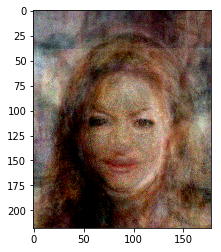

In [12]:
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

batch_size = 10
nd_steps = 10
ng_steps = 10
dataset = get_data_normalized(100)

for i in range(5000):
    X_batch = get_batch(batch_size, dataset)
    Z_batch = sample_Z(batch_size, 100)
    _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
    _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})

    print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))
Z_batch = sample_Z(1, 100)
X_batch = get_batch(1, dataset)
sess.run(G_sample, feed_dict={X: X_batch, Z: Z_batch})
plt.imshow(tf.reshape(G_sample, shape=(218,178,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch}))